<a href="https://colab.research.google.com/github/deendiran/Flood-Prediction-Utilizing-Satellite-Images/blob/main/notebooks/FloodPredictionModelTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio tensorflow numpy pandas geopandas opencv-python scikit-learn matplotlib

In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from osgeo import gdal
import geopandas as gpd
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import os


In [ ]:
def load_and_resize_band(file_path, target_shape):
    """
    Load a single band and resize it to target shape
    """
    try:
        with rasterio.open(file_path) as src:
            band = src.read(1)
            # Resize band to target shape
            resized = cv2.resize(band, target_shape, interpolation=cv2.INTER_LINEAR)
            return resized
    except Exception as e:
        print(f"Error loading band from {file_path}: {str(e)}")
        return None


In [ ]:
def load_sentinel2_bands(image_dir, base_filename, target_shape):
    """
    Load and resize required Sentinel-2 bands
    """
    bands = {}
    required_bands = {
        'B02': 'blue',   # Blue
        'B03': 'green',  # Green
        'B04': 'red',    # Red
        'B08': 'nir'     # NIR
    }

    for band_code, band_name in required_bands.items():
        # Find the file containing the band
        band_files = [f for f in os.listdir(image_dir)
                     if f.startswith(base_filename) and f'_{band_code}_' in f]

        if band_files:
            band_path = os.path.join(image_dir, band_files[0])
            resized_band = load_and_resize_band(band_path, target_shape)
            if resized_band is not None:
                bands[band_name] = resized_band

    return bands if len(bands) == len(required_bands) else None



In [ ]:
def calculate_ndvi(nir_band, red_band):

    epsilon = 1e-10
    denominator = nir_band + red_band + epsilon
    ndvi = (nir_band - red_band) / denominator
    return np.clip(ndvi, -1, 1)


In [ ]:
def calculate_ndwi(green_band, nir_band):
    """Calculate NDWI from GREEN and NIR bands"""
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    denominator = green_band + nir_band + epsilon
    ndwi = (green_band - nir_band) / denominator
    return np.clip(ndwi, -1, 1)

In [ ]:
def load_sentinel1_bands(image_dir, base_filename, target_shape):
    """
    Load and resize Sentinel-1 VV and VH bands
    """
    bands = {}
    required_polarizations = ['VV', 'VH']

    for pol in required_polarizations:
        pol_files = [f for f in os.listdir(image_dir)
                    if f.startswith(base_filename) and f'_{pol}.' in f]

        if pol_files:
            band_path = os.path.join(image_dir, pol_files[0])
            resized_band = load_and_resize_band(band_path, target_shape)
            if resized_band is not None:
                bands[pol.lower()] = resized_band

    return bands if len(bands) == len(required_polarizations) else None

In [ ]:
def calculate_soil_moisture_proxy(vv_band, vh_band):
    """Calculate soil moisture proxy from VV and VH bands"""
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    ratio = vh_band / (vv_band + epsilon)
    # Normalize to [0,1]
    normalized = (ratio - np.min(ratio)) / (np.max(ratio) - np.min(ratio) + epsilon)
    return normalized

In [ ]:
def process_data(image_folder, label_folder, target_shape=(128, 128)):
    """Process the dataset ensuring consistent shapes"""
    features = []
    labels = []

    for label_file in sorted(os.listdir(label_folder)):
        if not label_file.endswith('.geojson'):
            continue

        print(f"Processing label file: {label_file}")
        label_path = os.path.join(label_folder, label_file)

        try:
            geojson = gpd.read_file(label_path)
            if 'FLOODING' not in geojson.columns:
                continue

            flooding = geojson.loc[0, 'FLOODING']

            # Extract parts from filename
            parts = label_file.split('_')
            sensor_type = parts[0]  # s1 or s2
            digit = parts[2]
            date = "_".join(parts[3:6])

            # Construct base filename
            base_filename = f"{sensor_type}_source_{digit}_{date}"
            image_dir = os.path.join(image_folder, digit)

            if not os.path.exists(image_dir):
                continue

            if sensor_type == 's2':
                # Process Sentinel-2 data
                bands = load_sentinel2_bands(image_dir, base_filename, target_shape)
                if bands is not None:
                    ndvi = calculate_ndvi(bands['nir'], bands['red'])
                    ndwi = calculate_ndwi(bands['green'], bands['nir'])

                    # Stack features
                    feature_stack = np.dstack([ndvi, ndwi])
                    features.append(feature_stack)
                    labels.append(1 if flooding else 0)

            elif sensor_type == 's1':
                # Process Sentinel-1 data
                bands = load_sentinel1_bands(image_dir, base_filename, target_shape)
                if bands is not None:
                    soil_moisture = calculate_soil_moisture_proxy(bands['vv'], bands['vh'])

                    # Add soil moisture as single channel
                    feature_stack = np.expand_dims(soil_moisture, axis=-1)
                    features.append(feature_stack)
                    labels.append(1 if flooding else 0)

        except Exception as e:
            print(f"Error processing {label_file}: {str(e)}")
            continue

    if not features:
        return np.array([]), np.array([])

    # Ensure all features have the same shape before stacking
    first_shape = features[0].shape
    valid_features = [f for f in features if f.shape == first_shape]
    valid_labels = [l for i, l in enumerate(labels) if features[i].shape == first_shape]

    if not valid_features:
        return np.array([]), np.array([])

    # Stack features and convert labels
    X = np.stack(valid_features, axis=0)
    y = np.array(valid_labels)

    print(f"Processed {len(valid_features)} valid samples out of {len(features)} total")
    return X, y

In [ ]:
# Define the CNN model with multiple input channels
def create_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    return model

In [ ]:
if __name__ == "__main__":
    # Set paths
    image_folder = "/content/drive/MyDrive/train/images"
    label_folder = "/content/drive/MyDrive/train/labels"
    target_shape = (128, 128)  # Define target shape for all images

    # Process data
    print("Starting data processing...")
    X, y = process_data(image_folder, label_folder, target_shape)

    if X.size == 0:
        raise ValueError("No valid data was processed")

    print("Final dataset shape:", X.shape)
    print("Labels shape:", y.shape)

    # Normalize features
    X = (X - np.min(X)) / (np.max(X) - np.min(X) + 1e-10)

    # Convert labels to categorical
    y = to_categorical(y, num_classes=2)


Starting data processing...
Processing label file: s1_labels_0001_2018_12_23_labels.geojson
Processing label file: s1_labels_0001_2019_01_04_labels.geojson
Processing label file: s1_labels_0001_2019_01_16_labels.geojson
Processing label file: s1_labels_0001_2019_01_28_labels.geojson
Processing label file: s1_labels_0004_2018_12_16_labels.geojson
Processing label file: s1_labels_0004_2018_12_21_labels.geojson
Processing label file: s1_labels_0004_2018_12_28_labels.geojson
Processing label file: s1_labels_0004_2019_01_02_labels.geojson
Processing label file: s1_labels_0004_2019_01_09_labels.geojson
Processing label file: s1_labels_0005_2018_12_16_labels.geojson
Processing label file: s1_labels_0005_2018_12_21_labels.geojson
Processing label file: s1_labels_0005_2018_12_28_labels.geojson
Processing label file: s1_labels_0005_2019_01_02_labels.geojson
Processing label file: s1_labels_0005_2019_01_09_labels.geojson
Processing label file: s1_labels_0006_2018_12_16_labels.geojson
Processing l

In [ ]:
print("Shape of X:", X.shape)  # Should be (num_samples, height, width, channels)
print("Shape of y:", y.shape)  # Should be (num_samples,)


Shape of X: (200, 128, 128, 1)
Shape of y: (200, 2)


In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and compile model
model = create_model(input_shape=X.shape[1:])
model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Print model summary
model.summary()

# Train model
history = model.fit(X_train, y_train,
                       epochs=10,
                       batch_size=32,
                       validation_data=(X_test, y_test))

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Save the Model
model.save('my_model.keras')
print("Model saved successfully.")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,322 (12.60 MB)

 Trainable params: 3,304,322 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 388ms/step - accuracy: 0.5148 - loss: 0.6639 - val_accuracy: 0.8250 - val_loss: 0.6592
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6672 - loss: 0.6106 - val_accuracy: 0.8250 - val_loss: 0.4715
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8180 - loss: 0.3991 - val_accuracy: 0.8500 - val_loss: 0.3068
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9345 - loss: 0.2238 - val_accuracy: 0.8750 - val_loss: 0.2704
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9304 - loss: 0.2010 - val_accuracy: 0.9500 - val_loss: 0.1790
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9404 - loss: 0.1638 - val_accuracy: 0.9000 - val_loss: 0.2173
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9461 - loss: 0.1808 - val_accuracy: 0.9000 - val_loss: 0.2037
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9450 - loss: 0.1425 - val_accuracy: 0.9000 - val_loss: 0.169

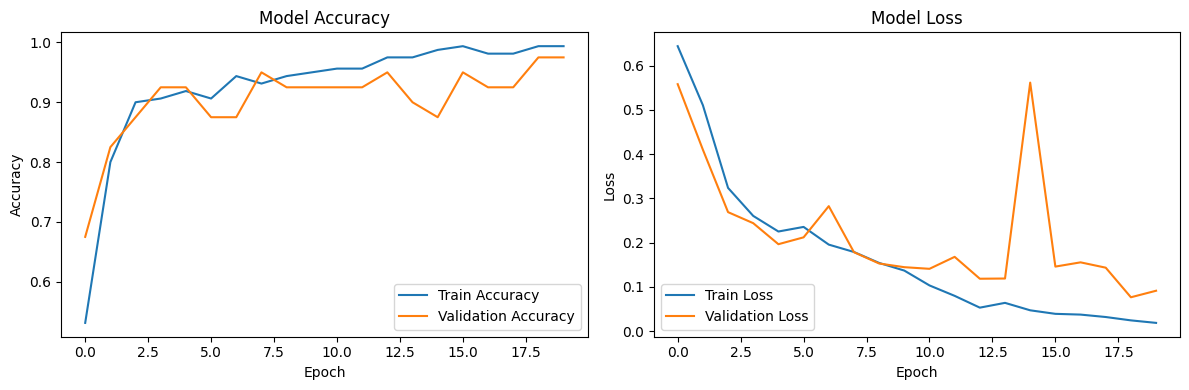

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generate predictions on the test data
y_pred = model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_test to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Calculate and display the classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=['No Flooding', 'Flooding'])

print("Classification Report:")
print(report)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 397ms/step
Classification Report:
              precision    recall  f1-score   support

 No Flooding       0.95      1.00      0.98        21
    Flooding       1.00      0.95      0.97        19

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

